# Playing with the MovieLens dataset

To do this thing, first download the MovieLens 100K dataset here: http://grouplens.org/datasets/movielens/
Then, in the directory where you will store this `.ipynb` file, create a subdirectory `data` in which you will extract the file `ml-100k.zip`.

## Import some stuff

In [88]:
import sys
import numpy as np
import matplotlib.pyplot as plt

In [89]:
f = open('data/ml-100k/u.data', encoding="latin-1")

## The data format

`u.data` has four fields: (1) user (2) item (3) rating (4) timestamp

What we'd like to do is first of all make some plots. A first plot we could do is the distribution of different ratings. To do that, we only need the rating field. Let's not keep too much in memory here, so that we could also work with bigger data sets if we wanted to. To create the first plot, we can walk through the file one by one, and create a dictionary of the values that `rating` takes as its keys, and the number of times a particular rating has been given as values. 

In [90]:
rating_counts = {}

In [91]:
for l in f:
    _, _, rating, _ = l.split('\t')
    rating = int(rating)
    if rating in rating_counts:
        rating_counts[rating] += 1
    else:
        rating_counts[rating] = 1
            

Now that we have walked through all the lines in the file, let's close it.

In [92]:
f.close()

In [93]:
ratings, counts = zip(*sorted(rating_counts.items()))

In [94]:
ratings, counts

((1, 2, 3, 4, 5), (6110, 11370, 27145, 34174, 21201))

## Doing a plot

In [95]:
%matplotlib inline

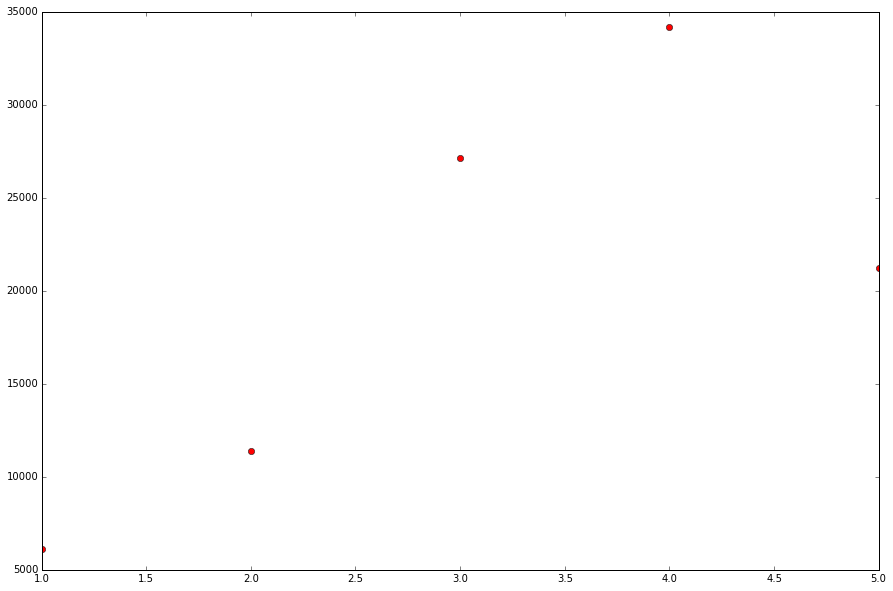

In [96]:
plt.figure(figsize=(15, 10))
plt.plot(ratings, counts, 'ro')

So, the plot above does not yet look very pretty, but we can see already that people tend to be positive about movies, with the most common rating in this sample dataset being four stars.

## A little jump: recommendation

Suppose we want to do some recommendation. The simplest one is just to retrieve a list of popular movies. The simplest algorithm there is to just count how many ratings a movie received, irrespective of the rating itself. For this, we aggregate over all the movies, it's very similar to what we did above

### Recommendation based on popularity








In [97]:
path_100k = 'data/ml-100k/u.data'
f = open(path_100k)

In [98]:
movie2nr_ratings = {}

In [99]:
for l in f:
    _, item, _, _ = l.split('\t')
    item = int(item)
    if item in movie2nr_ratings:
        movie2nr_ratings[item] += 1
    else:
        movie2nr_ratings[item] = 1


In [100]:
top_10 = sorted(movie2nr_ratings.items(), key=lambda x: x[1], reverse=True)[:10]

In [101]:
print(top_10)

[(50, 583), (258, 509), (100, 508), (181, 507), (294, 485), (286, 481), (288, 478), (1, 452), (300, 431), (121, 429)]


Now let's get the title for these top movies

In [102]:
f.close()
path_movie_info = 'data/ml-100k/u.item'
f = open(path_movie_info, encoding="latin-1")

In [103]:
movie_id2title = {}
for l in f:
    fields = l.split('|')
    movie_id = int(fields[0])
    title = fields[1]
    if movie_id in movie_id2title:
        print('Oops: duplicate movie_id')
    else:
        movie_id2title[movie_id] = title
f.close()

In [104]:
for movie_id, nr_ratings in top_10:
    print(movie_id2title[movie_id])

Star Wars (1977)
Contact (1997)
Fargo (1996)
Return of the Jedi (1983)
Liar Liar (1997)
English Patient, The (1996)
Scream (1996)
Toy Story (1995)
Air Force One (1997)
Independence Day (ID4) (1996)


So those are the top 10 most popular movie titles. Now let's go a step further and calculate similarities between movies. Then, given a movie, we will return a list of most similar movies.

### Recommendation based on similarity

So what we aim to do here is say: given a movie that you liked, what are similar movies? To compute similarity, we could look at many things: genre, box office revenue, actors that play in it, year that it came out and so on. But in this case, we'll stick to the user ratings: which other movies were similarly rated by all users? So intuitively, if the same users rated (viewed) a movie, the movie is similar. Note that we again do not use the actual ratings themselves yet, we merely use the information that a user viewed a movie, irrespective of the rating. To do this simplest similarity based approach, we need for each movie a list of users who rated the movie. This could become a rather big data structure. If everybody rated every movie, it could be as big as the number of movies in our dataset times the number of users in our data set. Fortunately, probably the data is sparse: each user will only have rated a limited number of movies: at least twenty, but certainly not everything.

In [105]:
movie_id2user_ids = {}

In [106]:
with open(path_100k, encoding="latin-1") as f:
    for l in f:
        user_id, movie_id, _, _ = l.split('\t')
        user_id = int(user_id)
        movie_id = int(movie_id)
        if movie_id in movie_id2user_ids:
            movie_id2user_ids[movie_id].add(user_id)
        else:
            movie_id2user_ids[movie_id] = set([user_id])
    

In [107]:
print(len(movie_id2user_ids.keys()))

1682


Ah, just checking. In the 100K movielens dataset there is data about 1682 movies. Now, if we were to create a similarity matrix of movies, then it would contain

In [108]:
1682**2

2829124

floating point values; that's close to three million. Now if we were to use the full MovieLens dataset, which has 30000 movies, then we would be looking at 900000000, that's close to a billion floating point values. If one floating point value needs 64bits, which is 8 bytes, already we would be using about this amount of memory (in G):

In [109]:
9 * 10**8 * 8 / 2 ** 30.0

6.705522537231445

That's close to 7GB. Now that would not comfortably fit anymore. So let's go for a different approach: let's, for a given movie, walk through all movies, compute similarity, and then sort that list. You could call this *online* computation of similarity. But how will we compute similarity between two movies exactly? There are many ways, look, e.g., at this web page for some example similarities: http://www.mickaellegal.com/blog/2014/1/30/how-to-build-a-recommender 

In our situation, we have sparse representations of user ratings. One similarity which is easy to compute on such representations is Jaccard similarity. It is defined as the number of items that are in *both* sets (the intersection of the two sets) divided by the number of items that are in either one of the sets (the union of the two sets). Let's create a function for Jaccard similarity.

In [110]:
def jaccard(a, b):
    return len(a & b) / float(len(a | b))

In [111]:
print(jaccard(set([1, 2, 3]), set([2, 3, 4])))

0.5


Remember that movie_id 50 was Star Wars (1977), the most popular movie? Let's see which movies are most similar to it.

In [112]:
my_movie_ratings = movie_id2user_ids[50]

In [118]:
my_movie_similarities = sorted([(movie_id, jaccard(my_movie_ratings, movie_ratings)) \
                         for movie_id, movie_ratings in movie_id2user_ids.items()], 
                               key=lambda x: x[1], reverse=True)[:10]

In [119]:
for movie_id, similarity in my_movie_similarities:
    print('%s (similarity: %.6f)' % (movie_id2title[movie_id], similarity))

Star Wars (1977) (similarity: 1.000000)
Return of the Jedi (1983) (similarity: 0.786885)
Raiders of the Lost Ark (1981) (similarity: 0.609952)
Toy Story (1995) (similarity: 0.582569)
Empire Strikes Back, The (1980) (similarity: 0.570248)
Fargo (1996) (similarity: 0.565280)
Godfather, The (1972) (similarity: 0.558685)
Independence Day (ID4) (1996) (similarity: 0.556923)
Silence of the Lambs, The (1991) (similarity: 0.525078)
Pulp Fiction (1994) (similarity: 0.510046)


The results are not counterintuitive. It makes sense that people who viewed Star Wars (1977) also largely viewed Return of the Jedi (1983).

What if I would like a list of recommendations based on all movies that I watched so far? A very straightforward way of going about this is to compute for all movies the *average* similarity to all the movies that I watched.

But we can also look into methods which are a bit more advanced. Suppose there are only two movies. Then we can plot two axes: one with the rating for movie A, and one with the rating for movie B. A point on this graph anywhere would give my ratings for both movies. We can do this for all users. And if we have three movies, we can make a plot like this with three axes. And if we have 30000 movies, we can still imagine a plot like this, with 30000 axes. But let's start with two dimensions to explain, e